In [1]:
%%capture
!pip install datasets evaluate transformers[sentencepiece]

In [2]:
# imports

import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!nvidia-smi

Tue Oct 18 21:18:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# mount my Google Drive directory and access the training data located there
gdrive_dir = '/content/gdrive/'
data_dir = os.path.join(gdrive_dir, "'My Drive'","'data'","cancer")
filename = 'bowel_cancer2.txt'

drive.mount(gdrive_dir, force_remount=True)

Mounted at /content/gdrive/


In [5]:
# copy the data to the current Colab working directory
!cp $data_dir/$filename .

In [6]:
# load into a data frame
df = pd.read_csv (filename, names=['text'])  
print(df)

                                                  text
0    Hello and thanks for your post. I’m sorry you’...
1    I'm sorry to hear that you have some ongoing h...
2       There is a lot of logic in what you are asking
3    Hello and thanks for your post. I'm sorry you ...
4    Hello and welcome to the community. I'm sorry ...
..                                                 ...
180  Hi sorry that you are experiencing these sympt...
181  I had my colonoscopy yesterday and they took a...
182  If your endoscopist suspected that your polyp ...
183                     Hello and thanks for your post
184  Welcome to Cancer Chat. I'm sorry to hear you ...

[185 rows x 1 columns]


In [7]:
df.dropna(inplace=True) #remove NA values
data = df.text.copy() #just use the main text in this example
data

0      Hello and thanks for your post. I’m sorry you’...
1      I'm sorry to hear that you have some ongoing h...
2         There is a lot of logic in what you are asking
3      Hello and thanks for your post. I'm sorry you ...
4      Hello and welcome to the community. I'm sorry ...
                             ...                        
180    Hi sorry that you are experiencing these sympt...
181    I had my colonoscopy yesterday and they took a...
182    If your endoscopist suspected that your polyp ...
183                       Hello and thanks for your post
184    Welcome to Cancer Chat. I'm sorry to hear you ...
Name: text, Length: 185, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


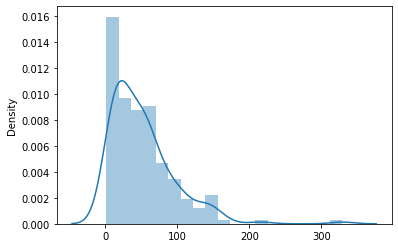

In [8]:
doc_lengths = []

for txt in data:

    # get rough token count distribution
    tokens = nltk.word_tokenize(txt)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)
sns.distplot(doc_lengths)

In [9]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0

In [10]:
# we are way under the 768 embedding size limit for the small GPT2 model.

np.average(doc_lengths)

51.58378378378379

In [11]:
# Although the defaults take care of this, we can add our own start of text and end of text tokens
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [13]:
# GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

batch_size = 2

In [14]:
# using the standard PyTorch approach of loading data in using a dataset class.
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [15]:
# we've wrapped each bio in the bos and eos tokens.
# Every tensor passed to the model should be the same length.
# If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens.
# If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

dataset = GPT2Dataset(data, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  166 training samples
   19 validation samples


In [16]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [17]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [18]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [19]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [20]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [21]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [22]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...

  Average training loss: 1.46
  Training epoch took: 0:00:45

Running Validation...
  Validation Loss: 0.27
  Validation took: 0:00:02

======== Epoch 2 / 5 ========
Training...

  Average training loss: 0.23
  Training epoch took: 0:00:43

Running Validation...
  Validation Loss: 0.24
  Validation took: 0:00:02

======== Epoch 3 / 5 ========
Training...

  Average training loss: 0.18
  Training epoch took: 0:00:43

Running Validation...
  Validation Loss: 0.23
  Validation took: 0:00:02

======== Epoch 4 / 5 ========
Training...

  Average training loss: 0.15
  Training epoch took: 0:00:43

Running Validation...
  Validation Loss: 0.23
  Validation took: 0:00:02

======== Epoch 5 / 5 ========
Training...

  Average training loss: 0.13
  Training epoch took: 0:00:43

Running Validation...
  Validation Loss: 0.24
  Validation took: 0:00:02

Training complete!
Total training took 0:03:44 (h:mm:ss)


In [23]:
# Let's view the summary of the training process.
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.46,0.27,0:00:45,0:00:02
2,0.23,0.24,0:00:43,0:00:02
3,0.18,0.23,0:00:43,0:00:02
4,0.15,0.23,0:00:43,0:00:02
5,0.13,0.24,0:00:43,0:00:02


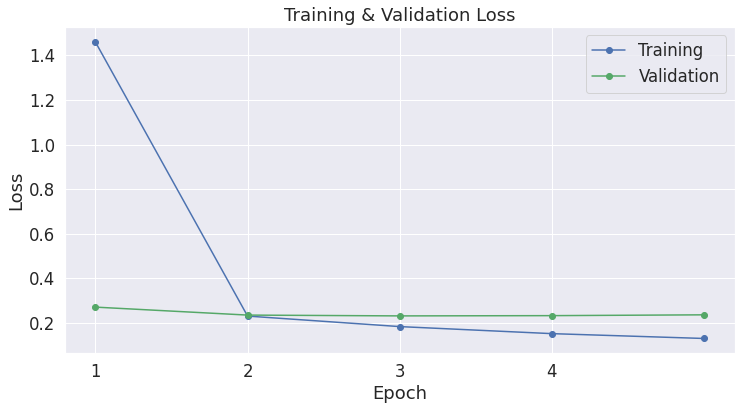

In [24]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [25]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [26]:
# Saving & Loading Fine-Tuned Model

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [27]:
!ls -l --block-size=K ./model_save/

total 499884K
-rw-r--r-- 1 root root      1K Oct 18 21:23 added_tokens.json
-rw-r--r-- 1 root root      1K Oct 18 21:23 config.json
-rw-r--r-- 1 root root    446K Oct 18 21:23 merges.txt
-rw-r--r-- 1 root root 498441K Oct 18 21:23 pytorch_model.bin
-rw-r--r-- 1 root root      1K Oct 18 21:23 special_tokens_map.json
-rw-r--r-- 1 root root      1K Oct 18 21:23 tokenizer_config.json
-rw-r--r-- 1 root root    976K Oct 18 21:23 vocab.json


In [28]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 487M Oct 18 21:23 ./model_save/pytorch_model.bin


In [29]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

In [33]:
# Generate Text

model.eval()

prompt = "<|startoftext|> I'm sorry to hear that you have some ongoing health issues. It's good to hear that your colonoscopy didn't give any cause for concern."

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 200,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257,   314,  1101,  7926,   284,  3285,   326,   345,   423,   617,
          7044,  1535,  2428,    13,   632,   338,   922,   284,  3285,   326,
           534,  7633, 17500, 11081,  1422,   470,  1577,   597,  2728,   329,
          2328,    13]], device='cuda:0')
0:  I'm sorry to hear that you have some ongoing health issues. It's good to hear that your colonoscopy didn't give any cause for concern. It was only used as a last resort after an inflammatory bowel disease diagnosis was passed on.  It was never very clear who might have been responsible for any of the problems you experienced.  You might have had another colonoscopy if you have had an inflammatory bowel disease.  The screening of your family history is very important.  It's important to take a biopsy.  You’ll need to fill out a colonoscopy kit that contains instructions for your doctor. You will not be offered anything.  You won’t be offered a test if you haven’t had anything to eat or drink for about 2 weeks